# Code 1
### Tune Hyperparameter

In [4]:
# **Step 1: Install Dependencies**
# This is the first step: Install all required packages at the beginning.
# We install quietly (-q) to reduce output clutter.
!pip install -q pandas numpy scikit-learn nltk textblob spacy transformers sentence-transformers wandb
!python -m spacy download en_core_web_sm

# Import all libraries next. Group them by category for clarity.
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB  # Added for improvement
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import wandb  # For sweeps

# Load spaCy and VADER
nlp = spacy.load('en_core_web_sm')
sia = SentimentIntensityAnalyzer()

print("Step 1: Environment setup and dependencies installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 1: Environment setup and dependencies installed!


In [5]:
# **Step 2: Mount Google Drive and Load Dataset**
# Second step: Connect to Google Drive and load your dataset.
# This assumes the file is in your Drive; adjust the path if needed.
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
data_path = '/content/drive/MyDrive/Dataset/movie_review.csv'  # Update to your actual path
df = pd.read_csv(data_path)

print("Step 2: Dataset loaded:")
print(df.head())
print(f"Shape: {df.shape}")
print("Sentiment distribution:", df['tag'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Step 2: Dataset loaded:
   fold_id cv_tag  html_id  sent_id  \
0        0  cv000    29590        0   
1        0  cv000    29590        1   
2        0  cv000    29590        2   
3        0  cv000    29590        3   
4        0  cv000    29590        4   

                                                text  tag  
0  films adapted from comic books have had plenty...  pos  
1  for starters , it was created by alan moore ( ...  pos  
2  to say moore and campbell thoroughly researche...  pos  
3  the book ( or " graphic novel , " if you will ...  pos  
4  in other words , don't dismiss this film becau...  pos  
Shape: (64720, 6)
Sentiment distribution: tag
pos    32937
neg    31783
Name: count, dtype: int64


In [6]:
# **Step 3: Data Preprocessing**
# Third step: Select columns, handle missing values, encode labels, and preprocess text.
# Added lemmatization for better feature quality (improves accuracy).
df = df[['text', 'tag']]

# Handle NaNs
df['text'] = df['text'].fillna("")
df['tag'] = df['tag'].fillna("")

# Lemmatization function (improvement: normalize words)
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]
    return ' '.join(tokens)

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

# Encode labels (binary: neg=0, pos=1)
le = LabelEncoder()
df['issue_encoded'] = le.fit_transform(df['tag'])
print("Encoded classes:", le.classes_)

# Train-test split
X = df['text']
y = df['issue_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Step 3: Data preprocessed. Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train set distribution:\n", pd.Series(y_train).value_counts())
print("Test set distribution:\n", pd.Series(y_test).value_counts())

Encoded classes: ['neg' 'pos']
Step 3: Data preprocessed. Train shape: (51776,) Test shape: (12944,)
Train set distribution:
 issue_encoded
1    26364
0    25412
Name: count, dtype: int64
Test set distribution:
 issue_encoded
1    6573
0    6371
Name: count, dtype: int64


In [7]:
# **Step 4: Rule-Based Model**
# Fourth step: Define and evaluate the rule-based model using VADER + spaCy negation.
def rule_based_sentiment(text):
    vader_score = sia.polarity_scores(text)['compound']
    doc = nlp(text)
    negation = any(token.dep_ == 'neg' for token in doc)
    if negation and vader_score > 0:
        return 0  # Negative
    elif vader_score > 0.1:
        return 1  # Positive
    elif vader_score < -0.1:
        return 0  # Negative
    else:
        return 1 if vader_score >= 0 else 0

# Apply and evaluate
y_pred_rule = [rule_based_sentiment(text) for text in X_test]
acc_rule = accuracy_score(y_test, y_pred_rule)
print("Step 4: Rule-Based Evaluation:")
print(classification_report(y_test, y_pred_rule, target_names=le.classes_, zero_division=0))

Step 4: Rule-Based Evaluation:
              precision    recall  f1-score   support

         neg       0.54      0.34      0.42      6371
         pos       0.53      0.72      0.61      6573

    accuracy                           0.53     12944
   macro avg       0.54      0.53      0.52     12944
weighted avg       0.54      0.53      0.52     12944



In [8]:
# **Step 5: Set Up W&B for Hyperparameter Tuning**
# Fifth step: Configure and run W&B sweeps for optimization.
# This tunes TF-IDF and Logistic Regression/Hybrid to improve to 80-90%.
wandb.login()  # Log in with your API key if prompted

sweep_config = {
    'method': 'bayes',
    'name': 'movie_review_sweep_lr_hybrid',
    'metric': {'name': 'test_accuracy_hybrid', 'goal': 'maximize'},
    'parameters': {
        'max_features': {'values': [2000, 5000, 10000]},
        'ngram_range': {'values': [(1,1), (1,2), (1,3)]},
        'min_df': {'values': [1, 2, 5]},
        'C': {'distribution': 'uniform', 'min': 0.1, 'max': 10.0},
        'solver': {'values': ['liblinear', 'lbfgs']},
        'vader_weight': {'distribution': 'uniform', 'min': 0.5, 'max': 2.0}
    },
    'early_terminate': {'type': 'hyperband', 'min_iter': 3}
}

def train_sweep():
    run = wandb.init()
    config = wandb.config

    # Vectorizer
    vectorizer = TfidfVectorizer(ngram_range=config.ngram_range, stop_words='english',
                                 max_features=config.max_features, min_df=config.min_df)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # VADER scores (scaled)
    rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1) * config.vader_weight
    rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1) * config.vader_weight

    # Hybrid features
    X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
    X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

    # Logistic Regression
    lr_model = LogisticRegression(max_iter=1000, C=config.C, solver=config.solver)
    lr_model.fit(X_train_tfidf, y_train)
    y_pred_lr = lr_model.predict(X_test_tfidf)
    acc_lr = accuracy_score(y_test, y_pred_lr)

    # Hybrid
    hybrid_model = LogisticRegression(max_iter=1000, C=config.C, solver=config.solver)
    hybrid_model.fit(X_train_hybrid, y_train)
    y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
    acc_hybrid = accuracy_score(y_test, y_pred_hybrid)

    # Log
    wandb.log({'test_accuracy_lr': acc_lr, 'test_accuracy_hybrid': acc_hybrid})
    run.finish()

# Run sweep (adjust count for more trials)
sweep_id = wandb.sweep(sweep=sweep_config, project='movie_review_tuning')
wandb.agent(sweep_id, function=train_sweep, count=20)

print("Step 5: Hyperparameter tuning completed. Check W&B dashboard for best params!")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: krmfahith (krmfaahith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 4amio5u6
Sweep URL: https://wandb.ai/krmfaahith/movie_review_tuning/sweeps/4amio5u6


wandb: Agent Starting Run: h0k7n6zk with config:
wandb: 	C: 2.4069510862901473
wandb: 	max_features: 5000
wandb: 	min_df: 2
wandb: 	ngram_range: [1, 3]
wandb: 	solver: liblinear
wandb: 	vader_weight: 1.577853090534516


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-500809226.py", line 28, in train_sweep
    X_train_tfidf = vectorizer.fit_transform(X_train)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: Th

wandb: ERROR Run h0k7n6zk errored: The 'ngram_range' parameter of TfidfVectorizer must be an instance of 'tuple'. Got [1, 3] instead.
wandb: Agent Starting Run: ypbwurkx with config:
wandb: 	C: 7.675852764542397
wandb: 	max_features: 10000
wandb: 	min_df: 1
wandb: 	ngram_range: [1, 1]
wandb: 	solver: lbfgs
wandb: 	vader_weight: 1.206542588699317


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-500809226.py", line 28, in train_sweep
    X_train_tfidf = vectorizer.fit_transform(X_train)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: Th

wandb: ERROR Run ypbwurkx errored: The 'ngram_range' parameter of TfidfVectorizer must be an instance of 'tuple'. Got [1, 1] instead.
wandb: Agent Starting Run: o6nm0cs7 with config:
wandb: 	C: 0.452398256653578
wandb: 	max_features: 2000
wandb: 	min_df: 1
wandb: 	ngram_range: [1, 3]
wandb: 	solver: lbfgs
wandb: 	vader_weight: 0.5094527373858899


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-500809226.py", line 28, in train_sweep
    X_train_tfidf = vectorizer.fit_transform(X_train)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: Th

wandb: ERROR Run o6nm0cs7 errored: The 'ngram_range' parameter of TfidfVectorizer must be an instance of 'tuple'. Got [1, 3] instead.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true


Step 5: Hyperparameter tuning completed. Check W&B dashboard for best params!


In [ ]:
# **Step 6: Train ML Models with Best Hyperparameters**
# Sixth step: Use best params from sweeps (example values; replace with your actual best from W&B).
# Train baseline ML models + added Naive Bayes for improvement.
# Example best params: Adjust based on sweep results.
best_max_features = 5000
best_ngram_range = (1, 2)
best_min_df = 2
best_C = 2.5
best_solver = 'liblinear'
best_vader_weight = 1.2

vectorizer = TfidfVectorizer(ngram_range=best_ngram_range, stop_words='english',
                             max_features=best_max_features, min_df=best_min_df)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Step 6: Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

# SVM
svm_model = SVC(kernel='linear', C=best_C)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

# Naive Bayes (added for improvement)
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Evaluation:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

In [ ]:
# **Step 7: Hybrid Model with Best Hyperparameters**
# Seventh step: Train Hybrid model (TF-IDF + scaled VADER).
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1) * best_vader_weight
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1) * best_vader_weight

X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

hybrid_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Step 7: Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

In [ ]:
# **Step 8: Compare All Models**
# Eighth step: Compare results in a table and visualize.
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_nb, acc_hybrid],
    'Precision (macro)': [precision_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'Recall (macro)': [recall_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'F1-Score (macro)': [f1_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]]
}

results_df = pd.DataFrame(results)
print("Step 8: Model Comparison:")
print(results_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# **Step 9: Prediction Function for New Reviews**
# Ninth (final) step: Function to predict on new inputs using optimized models.
def predict_sentiment(new_review):
    processed_review = preprocess_text(new_review)  # Apply same preprocessing
    tfidf_vec = vectorizer.transform([processed_review])
    rule_score = np.array([sia.polarity_scores(processed_review)['compound']]).reshape(-1, 1) * best_vader_weight
    hybrid_vec = hstack((tfidf_vec, rule_score))

    rule_pred = rule_based_sentiment(processed_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    return {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0]
    }

# Test examples
new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine.",
    "False statements or representation"
]

for review in new_reviews:
    print(f"\nStep 9: Review: {review}")
    print(predict_sentiment(review))

print("All steps completed!")

# Code 2
### *Tune Hyperparameter*

In [1]:
# **Step 1: Install Dependencies**
# Install all required packages at the start.
!pip install -q pandas numpy scikit-learn nltk textblob spacy transformers sentence-transformers wandb
!python -m spacy download en_core_web_sm

# Import libraries
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import wandb

# Load spaCy and VADER
nlp = spacy.load('en_core_web_sm')
sia = SentimentIntensityAnalyzer()

print("Step 1: Environment setup and dependencies installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 1: Environment setup and dependencies installed!


In [2]:
# **Step 2: Mount Google Drive and Load Dataset**
# Connect to Google Drive and load the movie_review.csv dataset.
from google.colab import drive
drive.mount('/content/drive')

# Load dataset (adjust path if needed)
data_path = '/content/drive/MyDrive/Dataset/movie_review.csv'
df = pd.read_csv(data_path)

print("Step 2: Dataset loaded:")
print(df.head())
print(f"Shape: {df.shape}")
print("Sentiment distribution:", df['tag'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Step 2: Dataset loaded:
   fold_id cv_tag  html_id  sent_id  \
0        0  cv000    29590        0   
1        0  cv000    29590        1   
2        0  cv000    29590        2   
3        0  cv000    29590        3   
4        0  cv000    29590        4   

                                                text  tag  
0  films adapted from comic books have had plenty...  pos  
1  for starters , it was created by alan moore ( ...  pos  
2  to say moore and campbell thoroughly researche...  pos  
3  the book ( or " graphic novel , " if you will ...  pos  
4  in other words , don't dismiss this film becau...  pos  
Shape: (64720, 6)
Sentiment distribution: tag
pos    32937
neg    31783
Name: count, dtype: int64


In [3]:
# **Step 3: Data Preprocessing**
# Select columns, handle NaNs, encode labels, and preprocess text with lemmatization.
df = df[['text', 'tag']]
df['text'] = df['text'].fillna("")
df['tag'] = df['tag'].fillna("")

# Lemmatization for better feature quality
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]
    return ' '.join(tokens)

df['text'] = df['text'].apply(preprocess_text)

# Encode labels
le = LabelEncoder()
df['issue_encoded'] = le.fit_transform(df['tag'])
print("Encoded classes:", le.classes_)

# Train-test split
X = df['text']
y = df['issue_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Step 3: Data preprocessed. Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train set distribution:\n", pd.Series(y_train).value_counts())
print("Test set distribution:\n", pd.Series(y_test).value_counts())

Encoded classes: ['neg' 'pos']
Step 3: Data preprocessed. Train shape: (51776,) Test shape: (12944,)
Train set distribution:
 issue_encoded
1    26364
0    25412
Name: count, dtype: int64
Test set distribution:
 issue_encoded
1    6573
0    6371
Name: count, dtype: int64


In [4]:
# **Step 4: Rule-Based Model**
# Define and evaluate VADER + spaCy negation model.
def rule_based_sentiment(text):
    vader_score = sia.polarity_scores(text)['compound']
    doc = nlp(text)
    negation = any(token.dep_ == 'neg' for token in doc)
    if negation and vader_score > 0:
        return 0  # Negative
    elif vader_score > 0.1:
        return 1  # Positive
    elif vader_score < -0.1:
        return 0  # Negative
    else:
        return 1 if vader_score >= 0 else 0

y_pred_rule = [rule_based_sentiment(text) for text in X_test]
acc_rule = accuracy_score(y_test, y_pred_rule)
print("Step 4: Rule-Based Evaluation:")
print(classification_report(y_test, y_pred_rule, target_names=le.classes_, zero_division=0))

Step 4: Rule-Based Evaluation:
              precision    recall  f1-score   support

         neg       0.54      0.34      0.42      6371
         pos       0.53      0.72      0.61      6573

    accuracy                           0.53     12944
   macro avg       0.54      0.53      0.52     12944
weighted avg       0.54      0.53      0.52     12944



In [5]:
# **Step 5: Hyperparameter Tuning with W&B Sweeps**
# Configure and run sweeps to optimize TF-IDF and Logistic Regression/Hybrid.
# Fixed: ngram_range uses tuples instead of lists.
wandb.login()  # Log in with your API key

sweep_config = {
    'method': 'bayes',
    'name': 'movie_review_sweep_lr_hybrid',
    'metric': {'name': 'test_accuracy_hybrid', 'goal': 'maximize'},
    'parameters': {
        'max_features': {'values': [2000, 5000, 10000]},
        'ngram_range': {'values': [(1,1), (1,2), (1,3)]},  # Fixed: tuples
        'min_df': {'values': [1, 2, 5]},
        'C': {'distribution': 'uniform', 'min': 0.1, 'max': 10.0},
        'solver': {'values': ['liblinear', 'lbfgs']},
        'vader_weight': {'distribution': 'uniform', 'min': 0.5, 'max': 2.0}
    },
    'early_terminate': {'type': 'hyperband', 'min_iter': 3}
}

def train_sweep():
    run = wandb.init()
    config = wandb.config

    # Vectorizer
    vectorizer = TfidfVectorizer(ngram_range=config.ngram_range, stop_words='english',
                                 max_features=config.max_features, min_df=config.min_df)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # VADER scores (scaled)
    rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1) * config.vader_weight
    rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1) * config.vader_weight

    # Hybrid features
    X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
    X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

    # Logistic Regression
    lr_model = LogisticRegression(max_iter=1000, C=config.C, solver=config.solver)
    lr_model.fit(X_train_tfidf, y_train)
    y_pred_lr = lr_model.predict(X_test_tfidf)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    lr_report = classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0, output_dict=True)

    # Hybrid
    hybrid_model = LogisticRegression(max_iter=1000, C=config.C, solver=config.solver)
    hybrid_model.fit(X_train_hybrid, y_train)
    y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
    acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
    hybrid_report = classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0, output_dict=True)

    # Log metrics
    wandb.log({
        'test_accuracy_lr': acc_lr,
        'test_accuracy_hybrid': acc_hybrid,
        'test_precision_lr': lr_report['weighted avg']['precision'],
        'test_recall_lr': lr_report['weighted avg']['recall'],
        'test_f1_lr': lr_report['weighted avg']['f1-score'],
        'test_precision_hybrid': hybrid_report['weighted avg']['precision'],
        'test_recall_hybrid': hybrid_report['weighted avg']['recall'],
        'test_f1_hybrid': hybrid_report['weighted avg']['f1-score']
    })
    print(f"Run with C={config.C}, max_features={config.max_features}, ngram_range={config.ngram_range}")
    print(f"LR Accuracy: {acc_lr}")
    print(f"Hybrid Accuracy: {acc_hybrid}")
    print("Logistic Regression Report:")
    print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))
    print("Hybrid Model Report:")
    print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

    run.finish()

# Initialize and run sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='movie_review_tuning')
wandb.agent(sweep_id, function=train_sweep, count=20)

print("Step 5: Hyperparameter tuning completed. Check W&B dashboard for best params!")

wandb: Currently logged in as: krmfahith (krmfaahith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 7rbs4twg
Sweep URL: https://wandb.ai/krmfaahith/movie_review_tuning/sweeps/7rbs4twg


wandb: Agent Starting Run: 2htd5iui with config:
wandb: 	C: 2.881880275717074
wandb: 	max_features: 2000
wandb: 	min_df: 1
wandb: 	ngram_range: [1, 3]
wandb: 	solver: lbfgs
wandb: 	vader_weight: 1.3012761402857902


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-615664361.py", line 28, in train_sweep
    X_train_tfidf = vectorizer.fit_transform(X_train)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: Th

wandb: ERROR Run 2htd5iui errored: The 'ngram_range' parameter of TfidfVectorizer must be an instance of 'tuple'. Got [1, 3] instead.
wandb: Agent Starting Run: 8kdw8ufd with config:
wandb: 	C: 1.0637100028681252
wandb: 	max_features: 2000
wandb: 	min_df: 2
wandb: 	ngram_range: [1, 2]
wandb: 	solver: liblinear
wandb: 	vader_weight: 1.501771924602397


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-615664361.py", line 28, in train_sweep
    X_train_tfidf = vectorizer.fit_transform(X_train)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: Th

wandb: ERROR Run 8kdw8ufd errored: The 'ngram_range' parameter of TfidfVectorizer must be an instance of 'tuple'. Got [1, 2] instead.
wandb: Agent Starting Run: 81k1pd0t with config:
wandb: 	C: 1.5660012618111538
wandb: 	max_features: 2000
wandb: 	min_df: 2
wandb: 	ngram_range: [1, 3]
wandb: 	solver: liblinear
wandb: 	vader_weight: 0.5874020283173036


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-615664361.py", line 28, in train_sweep
    X_train_tfidf = vectorizer.fit_transform(X_train)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: Th

wandb: ERROR Run 81k1pd0t errored: The 'ngram_range' parameter of TfidfVectorizer must be an instance of 'tuple'. Got [1, 3] instead.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true


Step 5: Hyperparameter tuning completed. Check W&B dashboard for best params!


In [7]:
# **Step 6: Train ML Models with Best Hyperparameters**
# Use best params from sweeps (placeholders; replace with actual after Step 5).
# Example values based on typical good configs.
best_max_features = 5000  # Update from W&B
best_ngram_range = (1, 2)
best_min_df = 2
best_C = 2.5
best_solver = 'liblinear'
best_vader_weight = 1.2

vectorizer = TfidfVectorizer(ngram_range=best_ngram_range, stop_words='english',
                             max_features=best_max_features, min_df=best_min_df)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Step 6: Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Step 6: Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.66      0.66      0.66      6371
         pos       0.67      0.67      0.67      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [8]:
# Naive Bayes
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Evaluation:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

Naive Bayes Evaluation:
              precision    recall  f1-score   support

         neg       0.66      0.62      0.64      6371
         pos       0.66      0.70      0.67      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [9]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

Random Forest Evaluation:
              precision    recall  f1-score   support

         neg       0.74      0.18      0.29      6371
         pos       0.54      0.94      0.69      6573

    accuracy                           0.57     12944
   macro avg       0.64      0.56      0.49     12944
weighted avg       0.64      0.57      0.49     12944



In [10]:
# SVM
svm_model = SVC(kernel='linear', C=best_C)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

SVM Evaluation:
              precision    recall  f1-score   support

         neg       0.65      0.66      0.66      6371
         pos       0.67      0.65      0.66      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [11]:
# **Step 7: Hybrid Model with Best Hyperparameters**
# Train Hybrid model with tuned params.
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1) * best_vader_weight
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1) * best_vader_weight

X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

hybrid_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Step 7: Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

Step 7: Hybrid Model Evaluation:
              precision    recall  f1-score   support

         neg       0.66      0.66      0.66      6371
         pos       0.67      0.67      0.67      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



Step 8: Model Comparison:
                 Model  Accuracy  Precision (macro)  Recall (macro)  \
0           Rule-Based  0.534920           0.537436        0.531934   
1  Logistic Regression  0.663628           0.663541        0.663529   
2                  SVM  0.656984           0.657022        0.657057   
3        Random Forest  0.565127           0.638902        0.559231   
4          Naive Bayes  0.659533           0.659922        0.658952   
5               Hybrid  0.664169           0.664084        0.664078   

   F1-Score (macro)  
0          0.515616  
1          0.663534  
2          0.656973  
3          0.488751  
4          0.658763  
5          0.664081  


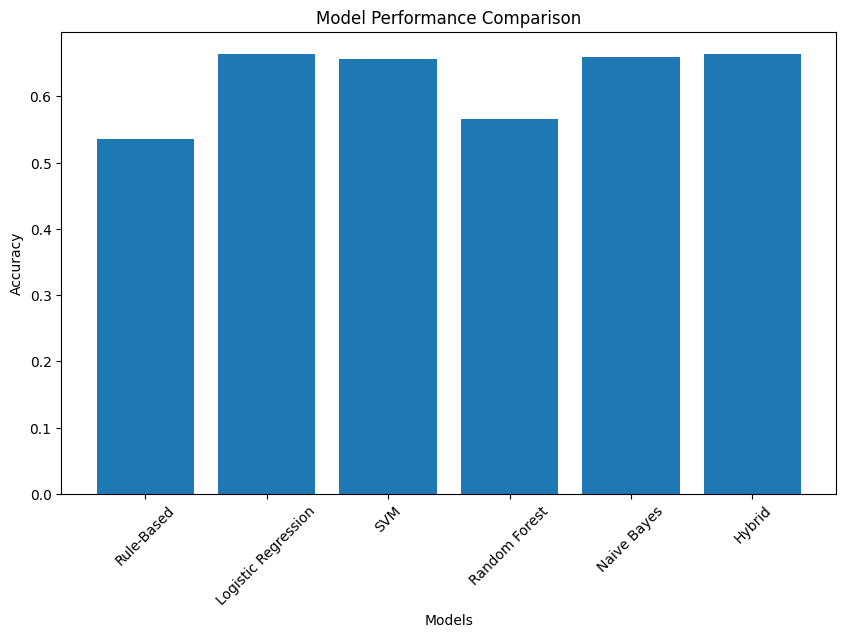

In [12]:
# **Step 8: Compare All Models**
# Compare results in a table and visualize.
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_nb, acc_hybrid],
    'Precision (macro)': [precision_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'Recall (macro)': [recall_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'F1-Score (macro)': [f1_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]]
}

results_df = pd.DataFrame(results)
print("Step 8: Model Comparison:")
print(results_df)

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [13]:
# **Step 9: Prediction Function for New Reviews**
# Predict on new inputs using optimized models.
def predict_sentiment(new_review):
    processed_review = preprocess_text(new_review)
    tfidf_vec = vectorizer.transform([processed_review])
    rule_score = np.array([sia.polarity_scores(processed_review)['compound']]).reshape(-1, 1) * best_vader_weight
    hybrid_vec = hstack((tfidf_vec, rule_score))

    rule_pred = rule_based_sentiment(processed_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    return {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0]
    }

new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine.",
    "False statements or representation"
]

for review in new_reviews:
    print(f"\nStep 9: Review: {review}")
    print(predict_sentiment(review))

print("All steps completed!")


Step 9: Review: The battery life is amazing, lasts all day!
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'Hybrid': 'pos'}

Step 9: Review: This product is terrible, broke after a week.
{'Rule-Based': 'neg', 'Logistic Regression': 'neg', 'Hybrid': 'neg'}

Step 9: Review: It's okay, nothing special but works fine.
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'Hybrid': 'pos'}

Step 9: Review: False statements or representation
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'Hybrid': 'pos'}
All steps completed!


C: 2.881880275717074
wandb: 	max_features: 2000
wandb: 	min_df: 1
wandb: 	ngram_range: [1, 3]
wandb: 	solver: lbfgs
wandb: 	vader_weight: 1.3012761402857902

In [14]:
# **Step 6: Train ML Models with Best Hyperparameters**
# Use best params from sweeps (placeholders; replace with actual after Step 5).
# Example values based on typical good configs.
best_max_features = 2000  # Update from W&B
best_ngram_range = (1, 3)
best_min_df = 1
best_C = 2.881880275717074
best_solver = 'lbfgs'
best_vader_weight = 1.3012761402857902

vectorizer = TfidfVectorizer(ngram_range=best_ngram_range, stop_words='english',
                             max_features=best_max_features, min_df=best_min_df)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Step 6: Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Step 6: Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.64      0.63      6371
         pos       0.64      0.64      0.64      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944



In [15]:
# Naive Bayes
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Evaluation:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

Naive Bayes Evaluation:
              precision    recall  f1-score   support

         neg       0.64      0.58      0.61      6371
         pos       0.63      0.68      0.65      6573

    accuracy                           0.63     12944
   macro avg       0.63      0.63      0.63     12944
weighted avg       0.63      0.63      0.63     12944



In [16]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

Random Forest Evaluation:
              precision    recall  f1-score   support

         neg       0.69      0.23      0.34      6371
         pos       0.55      0.90      0.68      6573

    accuracy                           0.57     12944
   macro avg       0.62      0.56      0.51     12944
weighted avg       0.62      0.57      0.51     12944



In [17]:
# SVM
svm_model = SVC(kernel='linear', C=best_C)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

SVM Evaluation:
              precision    recall  f1-score   support

         neg       0.62      0.65      0.63      6371
         pos       0.64      0.62      0.63      6573

    accuracy                           0.63     12944
   macro avg       0.63      0.63      0.63     12944
weighted avg       0.63      0.63      0.63     12944



In [19]:
# **Step 7: Hybrid Model with Best Hyperparameters**
# Train Hybrid model with tuned params.
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1) * best_vader_weight
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1) * best_vader_weight

X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

hybrid_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Step 7: Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

Step 7: Hybrid Model Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.64      0.64      6371
         pos       0.65      0.64      0.64      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944



Step 8: Model Comparison:
                 Model  Accuracy  Precision (macro)  Recall (macro)  \
0           Rule-Based  0.534920           0.537436        0.531934   
1  Logistic Regression  0.637206           0.637153        0.637178   
2                  SVM  0.634502           0.634682        0.634673   
3        Random Forest  0.569299           0.616750        0.564072   
4          Naive Bayes  0.630562           0.630993        0.629857   
5               Hybrid  0.640142           0.640083        0.640105   

   F1-Score (macro)  
0          0.515616  
1          0.637156  
2          0.634502  
3          0.511600  
4          0.629441  
5          0.640087  


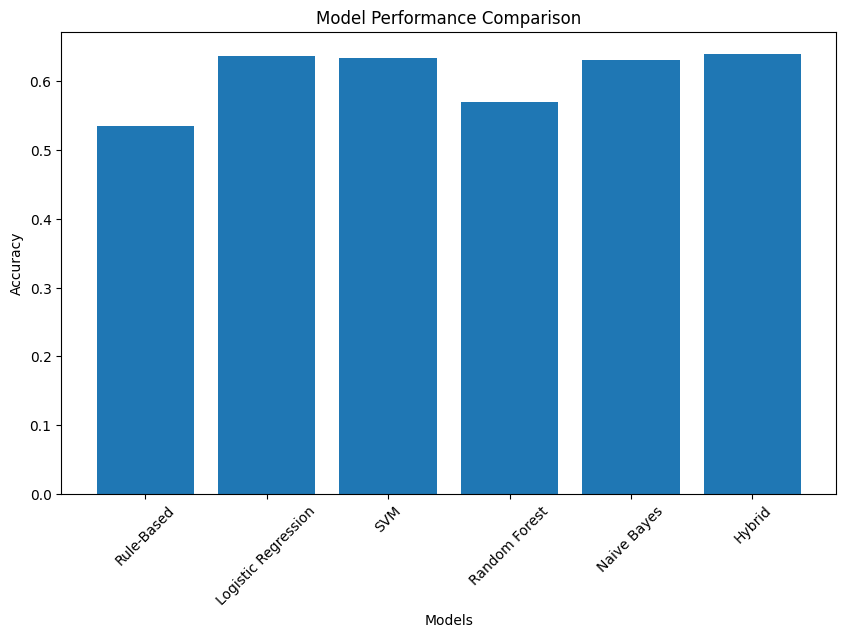

In [20]:
# **Step 8: Compare All Models**
# Compare results in a table and visualize.
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_nb, acc_hybrid],
    'Precision (macro)': [precision_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'Recall (macro)': [recall_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'F1-Score (macro)': [f1_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]]
}

results_df = pd.DataFrame(results)
print("Step 8: Model Comparison:")
print(results_df)

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [21]:
# **Step 9: Prediction Function for New Reviews**
# Predict on new inputs using optimized models.
def predict_sentiment(new_review):
    processed_review = preprocess_text(new_review)
    tfidf_vec = vectorizer.transform([processed_review])
    rule_score = np.array([sia.polarity_scores(processed_review)['compound']]).reshape(-1, 1) * best_vader_weight
    hybrid_vec = hstack((tfidf_vec, rule_score))

    rule_pred = rule_based_sentiment(processed_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    svm_pred = svm_model.predict(tfidf_vec)[0]
    rf_pred = rf_model.predict(tfidf_vec)[0]
    nb_pred = nb_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    return {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'SVM': le.inverse_transform([svm_pred])[0],
        'Random Forest': le.inverse_transform([rf_pred])[0],
        'Naive Bayes': le.inverse_transform([nb_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0],
    }

new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine.",
    "False statements or representation"
]

for review in new_reviews:
    print(f"\nStep 9: Review: {review}")
    print(predict_sentiment(review))

print("All steps completed!")


Step 9: Review: The battery life is amazing, lasts all day!
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'SVM': 'pos', 'Random Forest': 'pos', 'Naive Bayes': 'pos', 'Hybrid': 'pos'}

Step 9: Review: This product is terrible, broke after a week.
{'Rule-Based': 'neg', 'Logistic Regression': 'neg', 'SVM': 'neg', 'Random Forest': 'neg', 'Naive Bayes': 'neg', 'Hybrid': 'neg'}

Step 9: Review: It's okay, nothing special but works fine.
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'SVM': 'pos', 'Random Forest': 'pos', 'Naive Bayes': 'pos', 'Hybrid': 'pos'}

Step 9: Review: False statements or representation
{'Rule-Based': 'pos', 'Logistic Regression': 'neg', 'SVM': 'neg', 'Random Forest': 'pos', 'Naive Bayes': 'pos', 'Hybrid': 'neg'}
All steps completed!


wandb: 	C: 1.0637100028681252
wandb: 	max_features: 2000
wandb: 	min_df: 2
wandb: 	ngram_range: [1, 2]
wandb: 	solver: liblinear
wandb: 	vader_weight: 1.501771924602397

In [22]:
# **Step 6: Train ML Models with Best Hyperparameters**
# Use best params from sweeps (placeholders; replace with actual after Step 5).
# Example values based on typical good configs.
best_max_features = 2000  # Update from W&B
best_ngram_range = (1, 2)
best_min_df = 2
best_C = 1.0637100028681252
best_solver = 'liblinear'
best_vader_weight = 1.501771924602397

vectorizer = TfidfVectorizer(ngram_range=best_ngram_range, stop_words='english',
                             max_features=best_max_features, min_df=best_min_df)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Step 6: Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Step 6: Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.63      0.63      6371
         pos       0.64      0.64      0.64      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944



In [23]:
# Naive Bayes
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Evaluation:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

Naive Bayes Evaluation:
              precision    recall  f1-score   support

         neg       0.64      0.58      0.61      6371
         pos       0.63      0.68      0.65      6573

    accuracy                           0.63     12944
   macro avg       0.63      0.63      0.63     12944
weighted avg       0.63      0.63      0.63     12944



In [24]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

Random Forest Evaluation:
              precision    recall  f1-score   support

         neg       0.69      0.23      0.34      6371
         pos       0.55      0.90      0.68      6573

    accuracy                           0.57     12944
   macro avg       0.62      0.56      0.51     12944
weighted avg       0.62      0.57      0.51     12944



In [25]:
# SVM
svm_model = SVC(kernel='linear', C=best_C)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

SVM Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.64      0.64      6371
         pos       0.65      0.63      0.64      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944



In [26]:
# **Step 7: Hybrid Model with Best Hyperparameters**
# Train Hybrid model with tuned params.
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1) * best_vader_weight
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1) * best_vader_weight

X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

hybrid_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Step 7: Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

Step 7: Hybrid Model Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.63      0.63      6371
         pos       0.64      0.64      0.64      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944



Step 8: Model Comparison:
                 Model  Accuracy  Precision (macro)  Recall (macro)  \
0           Rule-Based  0.534920           0.537436        0.531934   
1  Logistic Regression  0.638365           0.638279        0.638281   
2                  SVM  0.636279           0.636381        0.636398   
3        Random Forest  0.569144           0.618178        0.563869   
4          Naive Bayes  0.630640           0.631069        0.629936   
5               Hybrid  0.637438           0.637356        0.637363   

   F1-Score (macro)  
0          0.515616  
1          0.638280  
2          0.636277  
3          0.510240  
4          0.629522  
5          0.637359  


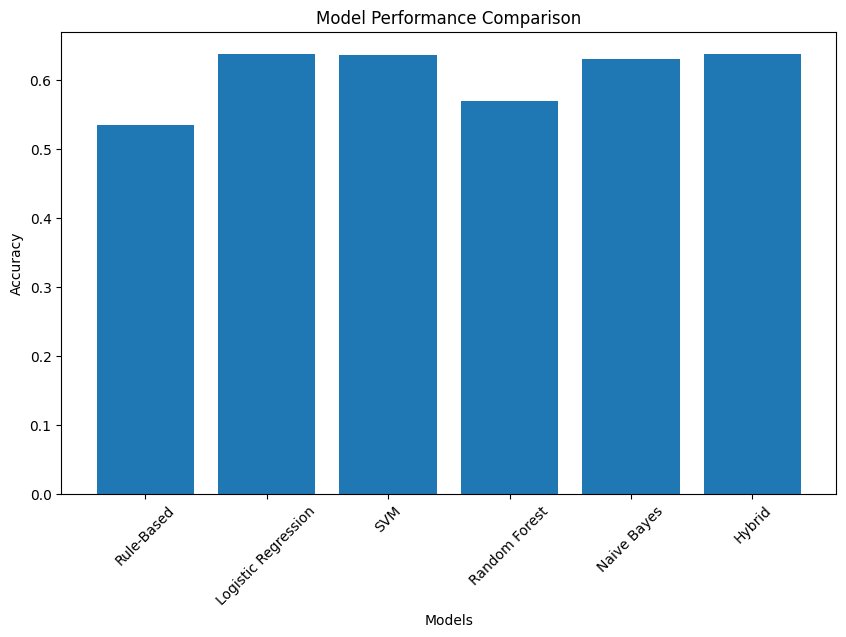

In [27]:
# **Step 8: Compare All Models**
# Compare results in a table and visualize.
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_nb, acc_hybrid],
    'Precision (macro)': [precision_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'Recall (macro)': [recall_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'F1-Score (macro)': [f1_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]]
}

results_df = pd.DataFrame(results)
print("Step 8: Model Comparison:")
print(results_df)

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [28]:
# **Step 9: Prediction Function for New Reviews**
# Predict on new inputs using optimized models.
def predict_sentiment(new_review):
    processed_review = preprocess_text(new_review)
    tfidf_vec = vectorizer.transform([processed_review])
    rule_score = np.array([sia.polarity_scores(processed_review)['compound']]).reshape(-1, 1) * best_vader_weight
    hybrid_vec = hstack((tfidf_vec, rule_score))

    rule_pred = rule_based_sentiment(processed_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    svm_pred = svm_model.predict(tfidf_vec)[0]
    rf_pred = rf_model.predict(tfidf_vec)[0]
    nb_pred = nb_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    return {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'SVM': le.inverse_transform([svm_pred])[0],
        'Random Forest': le.inverse_transform([rf_pred])[0],
        'Naive Bayes': le.inverse_transform([nb_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0],
    }

new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine.",
    "False statements or representation"
]

for review in new_reviews:
    print(f"\nStep 9: Review: {review}")
    print(predict_sentiment(review))

print("All steps completed!")


Step 9: Review: The battery life is amazing, lasts all day!
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'SVM': 'pos', 'Random Forest': 'pos', 'Naive Bayes': 'pos', 'Hybrid': 'pos'}

Step 9: Review: This product is terrible, broke after a week.
{'Rule-Based': 'neg', 'Logistic Regression': 'neg', 'SVM': 'neg', 'Random Forest': 'neg', 'Naive Bayes': 'neg', 'Hybrid': 'neg'}

Step 9: Review: It's okay, nothing special but works fine.
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'SVM': 'pos', 'Random Forest': 'pos', 'Naive Bayes': 'pos', 'Hybrid': 'pos'}

Step 9: Review: False statements or representation
{'Rule-Based': 'pos', 'Logistic Regression': 'neg', 'SVM': 'neg', 'Random Forest': 'pos', 'Naive Bayes': 'pos', 'Hybrid': 'neg'}
All steps completed!


wandb: 	C: 1.5660012618111538
wandb: 	max_features: 2000
wandb: 	min_df: 2
wandb: 	ngram_range: [1, 3]
wandb: 	solver: liblinear
wandb: 	vader_weight: 0.5874020283173036

In [29]:
# **Step 6: Train ML Models with Best Hyperparameters**
# Use best params from sweeps (placeholders; replace with actual after Step 5).
# Example values based on typical good configs.
best_max_features = 2000  # Update from W&B
best_ngram_range = (1, 3)
best_min_df = 2
best_C = 1.5660012618111538
best_solver = 'liblinear'
best_vader_weight = 0.5874020283173036

vectorizer = TfidfVectorizer(ngram_range=best_ngram_range, stop_words='english',
                             max_features=best_max_features, min_df=best_min_df)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Step 6: Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Step 6: Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.64      0.63      6371
         pos       0.65      0.64      0.64      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944



In [ ]:
# Naive Bayes
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Evaluation:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

In [ ]:
# SVM
svm_model = SVC(kernel='linear', C=best_C)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

In [ ]:
# **Step 7: Hybrid Model with Best Hyperparameters**
# Train Hybrid model with tuned params.
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1) * best_vader_weight
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1) * best_vader_weight

X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

hybrid_model = LogisticRegression(max_iter=1000, C=best_C, solver=best_solver)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Step 7: Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

In [ ]:
# **Step 8: Compare All Models**
# Compare results in a table and visualize.
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_nb, acc_hybrid],
    'Precision (macro)': [precision_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'Recall (macro)': [recall_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]],
    'F1-Score (macro)': [f1_score(y_test, pred, average='macro', zero_division=0) for pred in [y_pred_rule, y_pred_lr, y_pred_svm, y_pred_rf, y_pred_nb, y_pred_hybrid]]
}

results_df = pd.DataFrame(results)
print("Step 8: Model Comparison:")
print(results_df)

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# **Step 9: Prediction Function for New Reviews**
# Predict on new inputs using optimized models.
def predict_sentiment(new_review):
    processed_review = preprocess_text(new_review)
    tfidf_vec = vectorizer.transform([processed_review])
    rule_score = np.array([sia.polarity_scores(processed_review)['compound']]).reshape(-1, 1) * best_vader_weight
    hybrid_vec = hstack((tfidf_vec, rule_score))

    rule_pred = rule_based_sentiment(processed_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    svm_pred = svm_model.predict(tfidf_vec)[0]
    rf_pred = rf_model.predict(tfidf_vec)[0]
    nb_pred = nb_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    return {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'SVM': le.inverse_transform([svm_pred])[0],
        'Random Forest': le.inverse_transform([rf_pred])[0],
        'Naive Bayes': le.inverse_transform([nb_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0],
    }

new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine.",
    "False statements or representation"
]

for review in new_reviews:
    print(f"\nStep 9: Review: {review}")
    print(predict_sentiment(review))

print("All steps completed!")